In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer

In [28]:
df = pd.read_csv('../loan_approval/data/Copy of loan - loan.csv')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [30]:
df.shape

(614, 13)

In [31]:
df.duplicated().sum()

0

In [32]:
missing_vals = df.isnull().sum().loc[lambda x: x > 0].to_dict()


In [34]:
# checking what percentage of data is null 
data=[]
total_vals = df.shape[0]
for feature , value in missing_vals.items():
    data.append([ feature,value, (value / total_vals)*100 , df[feature].dtype])

pd.DataFrame(
    data , columns  =["featues" , "missing values" , "missing data %" , "Dtype"]
)

,featues,missing values,missing data %,Dtype
0,Gender,13,2.117264,object
1,Married,3,0.488599,object
2,Dependents,15,2.442997,object
3,Self_Employed,32,5.211726,object
4,LoanAmount,22,3.583062,float64
5,Loan_Amount_Term,14,2.280130,float64
6,Credit_History,50,8.143322,float64


### Data Cleaning

In [14]:
# changing target column datatype
df['Loan_Status'] = df['Loan_Status'].apply(lambda x : 1 if x == "Y" else 0)

In [15]:
df['Gender'] = df["Gender"].fillna(df['Gender'].mode()[0])
df['Married'] = df["Married"].fillna(df['Married'].mode()[0])
df['Dependents'] = df["Dependents"].fillna(df['Dependents'].mode()[0])
df['Self_Employed'] = df["Self_Employed"].fillna("Unknown")
df['Loan_Amount_Term'] = df["Loan_Amount_Term"].fillna(df['Loan_Amount_Term'].mode()[0])
df['Credit_History'] = df["Credit_History"].fillna(df['Credit_History'].mode()[0])

# grouped based imputation of null values based on Education
df['LoanAmount'] = df.groupby('Education')['LoanAmount'].transform(lambda x: x.fillna(x.median()))

In [16]:
# Count of numercial and categorical features

num_cols = df.select_dtypes(include='number').columns
cat_cols = df.select_dtypes(exclude='number').columns
print("No. of numerical columns : " ,len(num_cols) )
print("No. of categorical columns : " , len(cat_cols))

No. of numerical columns :  6
No. of categorical columns :  7


In [17]:
print(num_cols)
print(cat_cols)

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Loan_Status'],
      dtype='object')
Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Property_Area'],
      dtype='object')


# Exploratory data Analysis

## Univariate Analysis

### Numerical Features

In [11]:
df[num_cols].columns

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Loan_Status'],
      dtype='object')

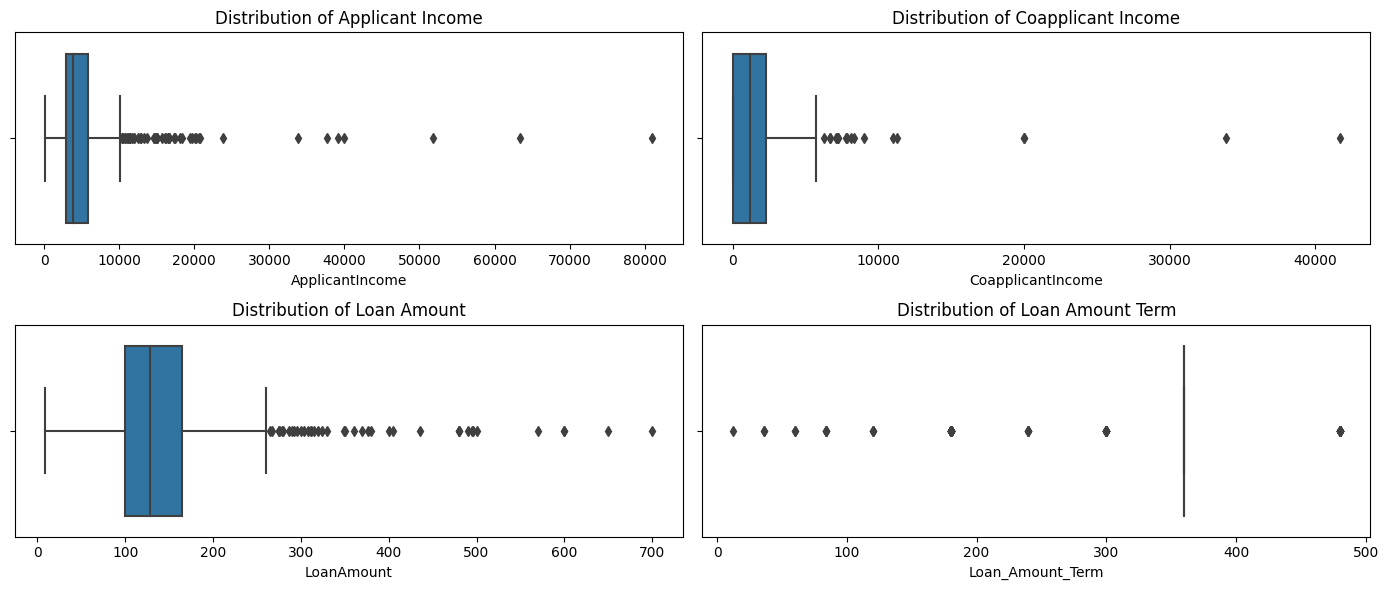

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(14, 6))

sns.boxplot(data=df, x="ApplicantIncome", ax=axes[0, 0])
axes[0, 0].set_title("Distribution of Applicant Income")

sns.boxplot(data=df, x="CoapplicantIncome", ax=axes[0, 1])
axes[0, 1].set_title("Distribution of Coapplicant Income")

sns.boxplot(data=df, x="LoanAmount", ax=axes[1, 0])
axes[1, 0].set_title("Distribution of Loan Amount")

sns.boxplot(data=df, x="Loan_Amount_Term", ax=axes[1, 1])
axes[1, 1].set_title("Distribution of Loan Amount Term")

plt.tight_layout()
plt.show()


In [13]:
num_cols_outliers = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount','Loan_Amount_Term']
data = []

for col in num_cols_outliers:
    q1 = np.percentile(df[col] , 25)
    q2 = np.percentile(df[col] , 50)
    q3 = np.percentile(df[col] , 75)

    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    no_outliers =  df[df[col] < lower_bound].shape[0]+ df[df[col] > upper_bound].shape[0]
    outlier_perc = (no_outliers / total_vals) * 100

    data.append([ col, q1 , q2 , q3 ,  iqr , lower_bound , upper_bound , no_outliers , outlier_perc])

outlier_report = pd.DataFrame(
    data=data , 
    columns = [
    'Feature',
    'Q1' ,
    'Q2',
    'Q3',
    'IQR',
    'Lower Bound',
    'Upper Bound',
    'Number of Outliers',
    'Outlier Percentage'
]
)
outlier_report

,Feature,Q1,Q2,Q3,IQR,Lower Bound,Upper Bound,Number of Outliers,Outlier Percentage
0,ApplicantIncome,2877.50,3812.5,5795.00,2917.50,-1498.750,10171.250,50,8.143322
1,CoapplicantIncome,0.00,1188.5,2297.25,2297.25,-3445.875,5743.125,18,2.931596
2,LoanAmount,100.25,128.0,164.75,64.50,3.500,261.500,41,6.677524
3,Loan_Amount_Term,360.00,360.0,360.00,0.00,360.000,360.000,88,14.332248


In [14]:
# Cause of outliers in income
df[df['ApplicantIncome'] > 10171.250]['Education'].value_counts()

Graduate        48
Not Graduate     2
Name: Education, dtype: int64

In [15]:
# Cause of outliers in income
print("Self-Employed:")
print(df[df['LoanAmount'] > 261.500]['Self_Employed'].value_counts())
print("\n")
print("Education:")
print(df[df['LoanAmount'] > 261.500]['Education'].value_counts())

Self-Employed:
No         29
Yes         9
Unknown     3
Name: Self_Employed, dtype: int64


Education:
Graduate        40
Not Graduate     1
Name: Education, dtype: int64


- It seems all values that are not 360  are flagged as outliers in Loan amount term so they are not outliers.
- Incomes can have high variance, as we can see there are more graduates in outliers.
- Same goes of co-applicant income.
- People having degree and working in job requres huge loans.

C:\Users\windows\AppData\Local\Temp\ipykernel_12088\1306403966.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr() , annot=True)


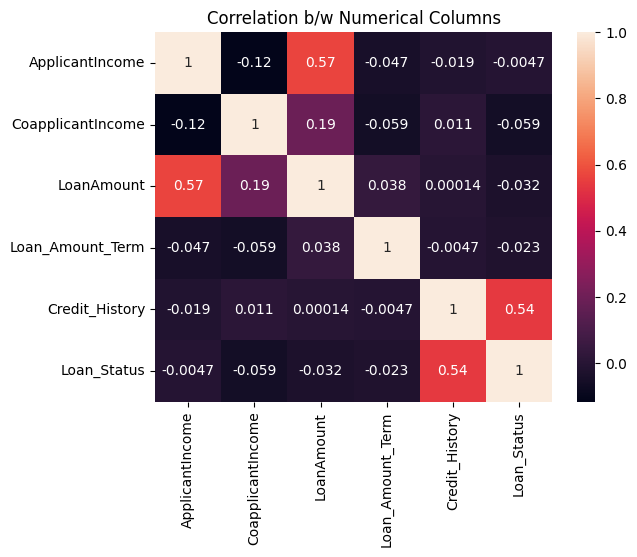

In [16]:
sns.heatmap(df.corr() , annot=True)
plt.title("Correlation b/w Numerical Columns")
plt.show()

- Loan Status have positive correlation with credit history.
- ApplicantIncome , CoApplicant Income and Loan Amount have very low negative correlation with target.
- ApplicatnIncome have strong correaltion with Loan Amount (higher income leads to higher loan amounts).
- CoapplicantIncome have mild positive correlation with loan amount.

### Categorical Features

In [17]:
cat_cols = list(cat_cols)
cat_cols.append('Loan_Status')
cat_cols

['Loan_ID',
 'Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Property_Area',
 'Loan_Status']

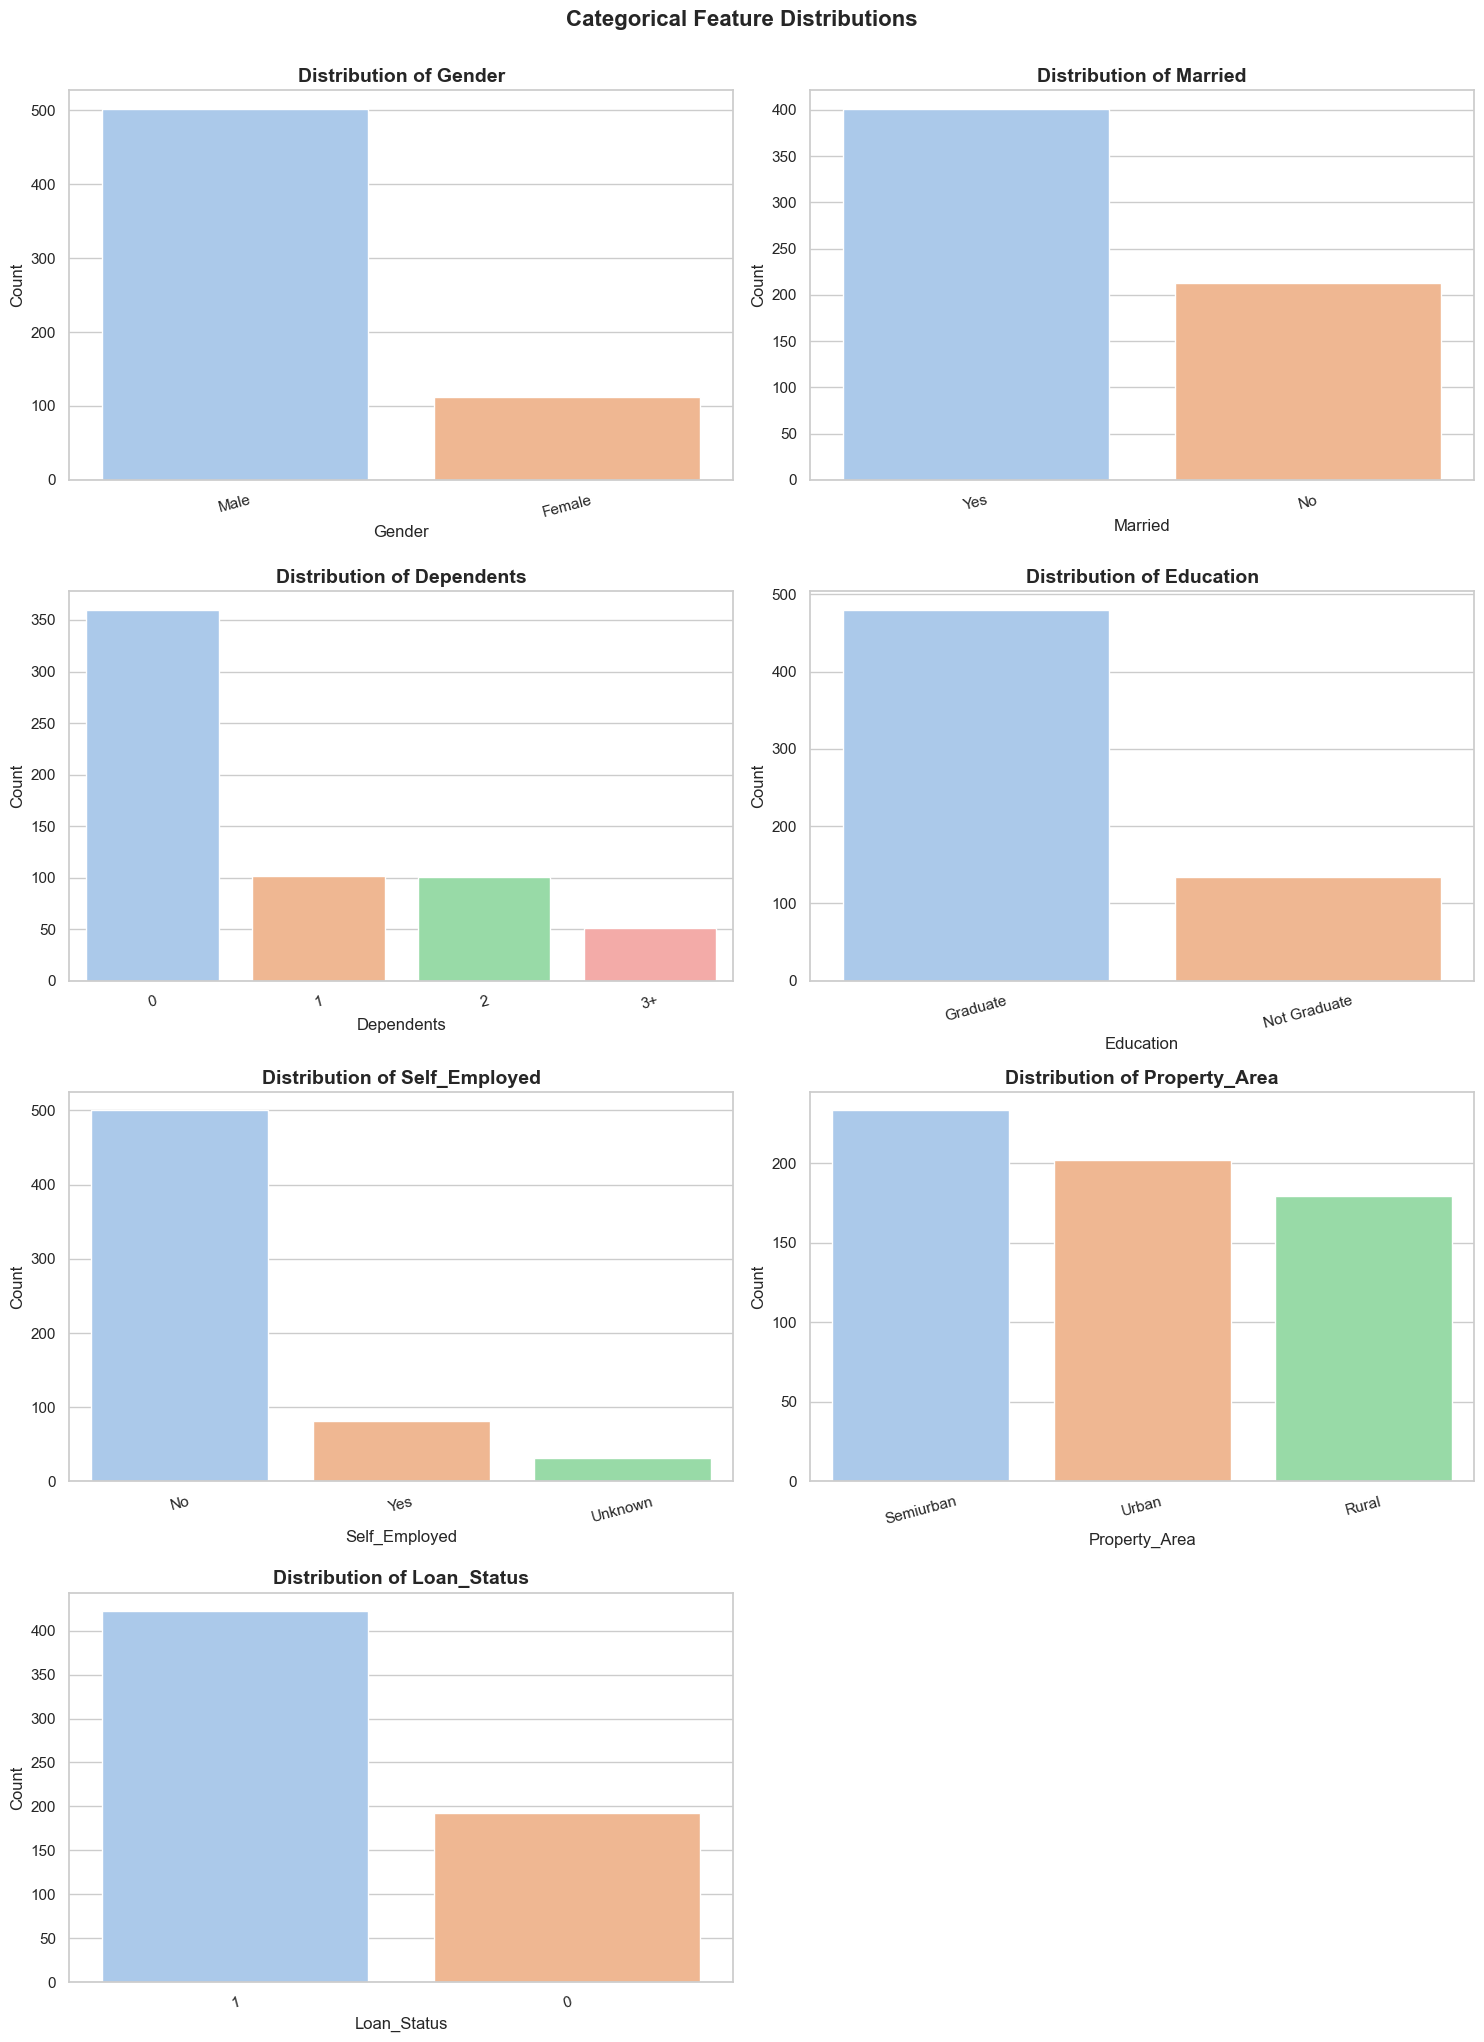

In [18]:
sns.set(style="whitegrid", palette="pastel")

# Plot each categorical column
plt.figure(figsize=(15, 20))  # Set a large figure size
for i, col in enumerate(cat_cols[1:], 1):
    plt.subplot(4, 2, i)  # 4 rows, 2 columns layout
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f'Distribution of {col}', fontsize=14, fontweight='bold')
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=15)

plt.tight_layout()
plt.suptitle("Categorical Feature Distributions", fontsize=16, fontweight='bold', y=1.02)
plt.show()

- Data is Imbalanced , It consist more approval records than not approved records.
- More Graduates are there compared to non gradutes.
- Most of the applicant are doing jobs.
- Most of the applicant have 0 dependents.
- Property ownership of applicants varies in diffrent areas.

### Realtionship with Target

,ApplicantIncome
Property_Area,
Rural,5554.083799
Semiurban,5292.261803
Urban,5398.247525


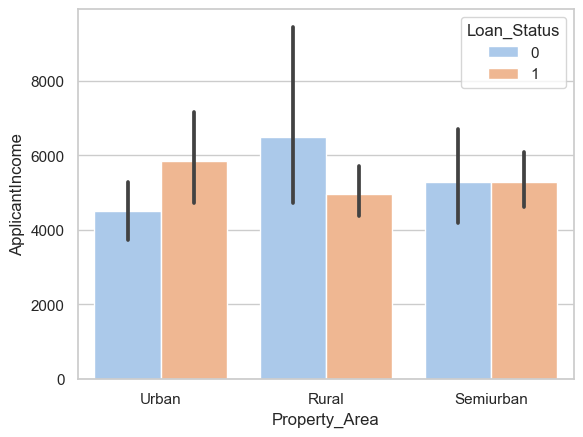

In [19]:
# Checking Affects of Property area on Loan Approval
sns.barplot(data=df, x="Property_Area", y="ApplicantIncome",hue="Loan_Status" )
income_area = df[['Property_Area', 'ApplicantIncome']]
income_area.groupby(['Property_Area']).mean()

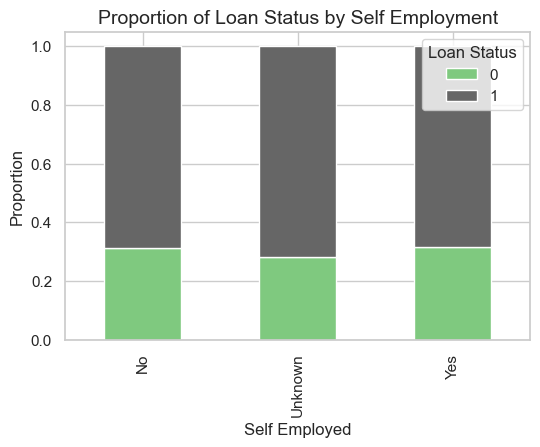

In [20]:
cross_tab = pd.crosstab(df['Self_Employed'], df['Loan_Status'], normalize='index')

# Plot
cross_tab.plot(kind='bar', stacked=True, colormap='Accent', figsize=(6,4))
plt.title('Proportion of Loan Status by Self Employment', fontsize=14)
plt.xlabel('Self Employed')
plt.ylabel('Proportion')
plt.legend(title='Loan Status', loc='upper right')
plt.show()

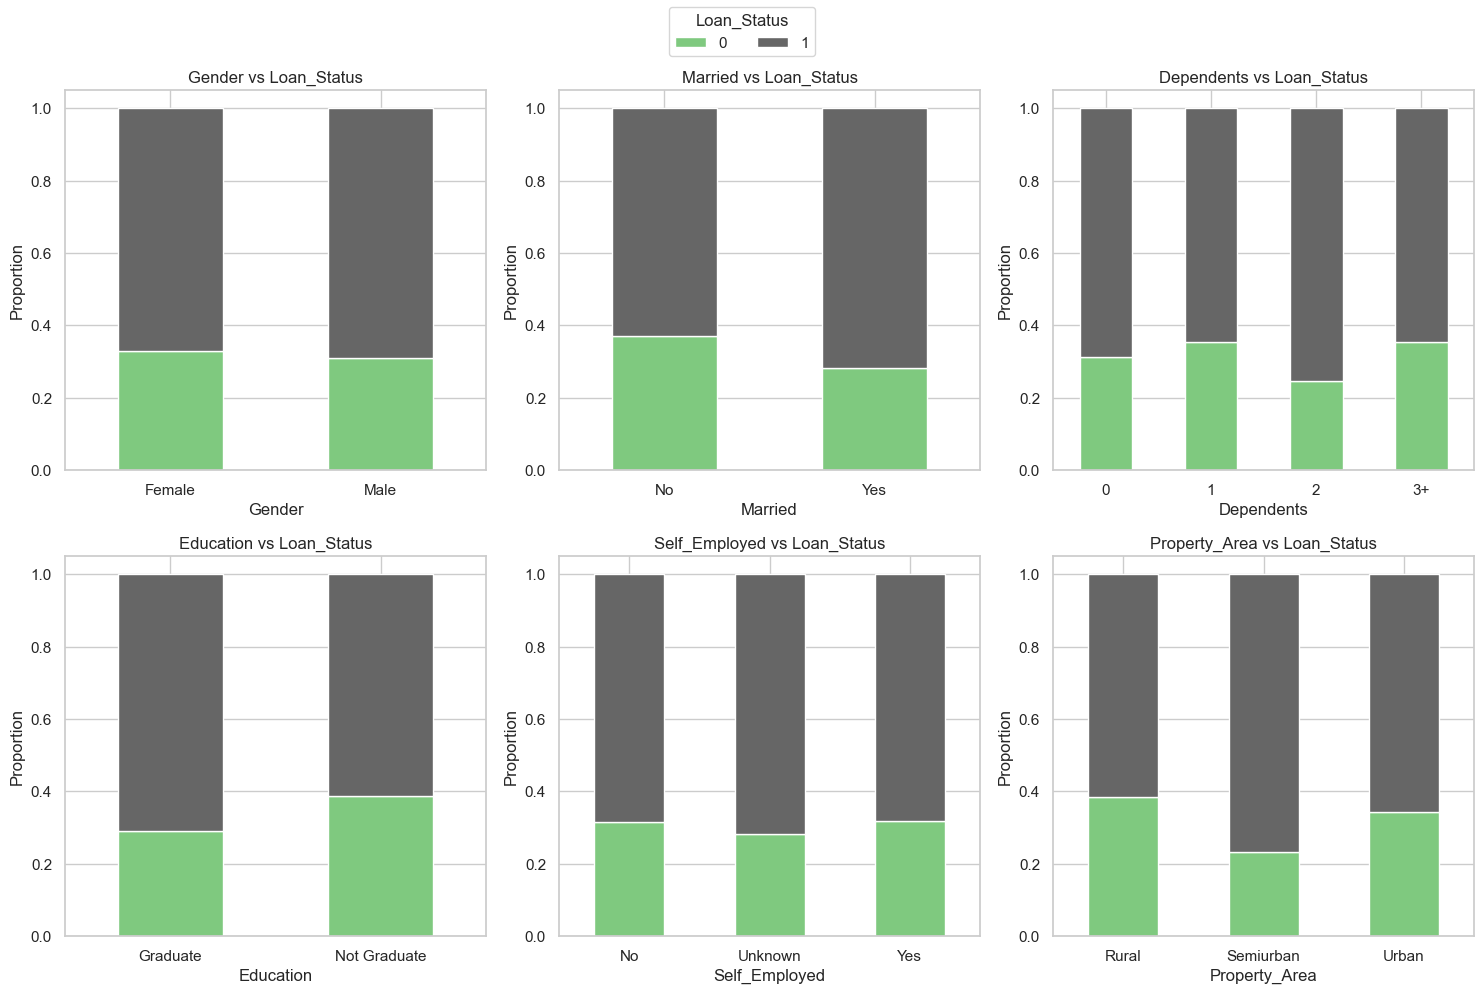

In [21]:
cat_cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']
n_cols = 3
n_rows = (len(cat_cols) + n_cols - 1) // n_cols

plt.figure(figsize=(15, 10))

for idx, col in enumerate(cat_cols, 1):
    plt.subplot(n_rows, n_cols, idx)
    
    cross_tab = pd.crosstab(df[col], df['Loan_Status'], normalize='index')
    cross_tab.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='Accent', legend=False)
    
    plt.title(f'{col} vs Loan_Status')
    plt.xlabel(col)
    plt.ylabel('Proportion')
    plt.xticks(rotation=0)

# Add legend outside the plots
handles, labels = plt.gca().get_legend_handles_labels()
plt.figlegend(handles, labels, loc='upper center', ncol=2, title='Loan_Status')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

- **Gender**: Approval rates are similar for both males and females, though slightly lower for females.
- **Married**: Married applicants have a slightly higher loan approval proportion than unmarried ones.
- **Dependents**: Applicants with 2 dependents show noticeably lower approval rates compared to others.
- **Education**: Non-graduates seem to have lower loan approval rates than graduates.
- **Self_Employed**: Self-employed individuals have a lower approval rate compared to non-self-employed.
- **Property_Area**: Applicants from Semiurban areas have the highest loan approval rate, followed by Urban and then Rural areas.


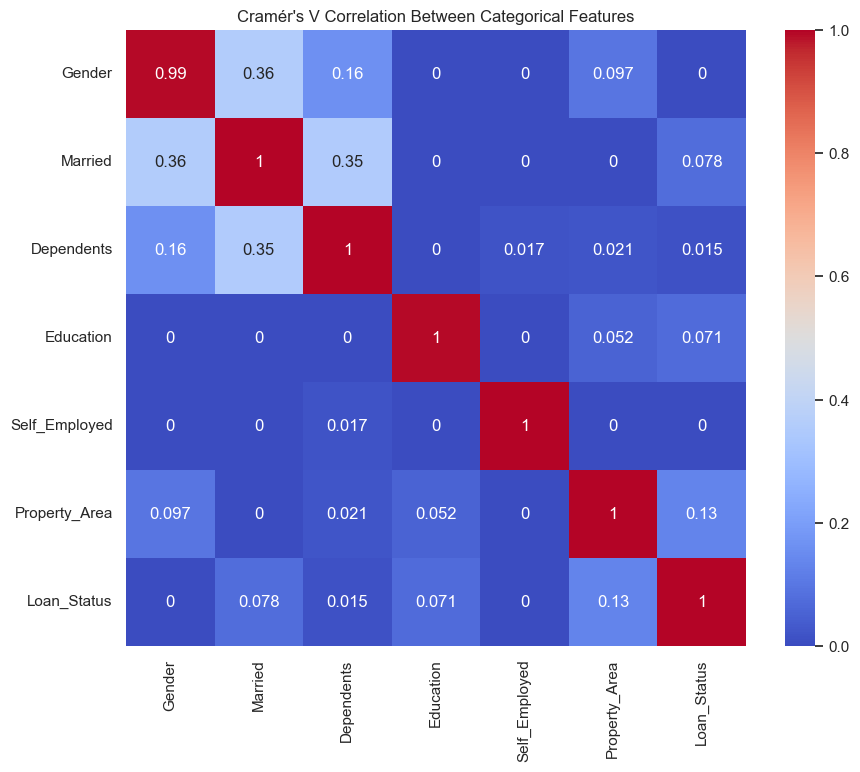

In [22]:
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

cat_cols = ['Gender', 'Married', 'Dependents', 'Education', 
            'Self_Employed', 'Property_Area', 'Loan_Status']

cramers_results = pd.DataFrame(index=cat_cols, columns=cat_cols)

for col1 in cat_cols:
    for col2 in cat_cols:
        cramers_results.loc[col1, col2] = cramers_v(df[col1], df[col2])

# Convert to float
cramers_results = cramers_results.astype(float)

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(cramers_results, annot=True, cmap='coolwarm')
plt.title("Cramér's V Correlation Between Categorical Features")
plt.show()


- Gender and Self_Employed column have less no correlation with Loan_Status.
- Married , Dependents and Education have little positive correlation.
- Propert_Area have a more positive correlation to target compared to other features.
- Married and Gender have strong positive correlation.
- Married and Dependents have strong positive correlation.

# Model Building

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report , accuracy_score , f1_score
from sklearn.metrics import average_precision_score, precision_score, recall_score, roc_auc_score , precision_recall_curve
from sklearn.model_selection import cross_val_score

In [24]:
# df['Loan_Term_Years'] = df['Loan_Amount_Term'] / 12
# df['Monthly_Installment'] = df['LoanAmount'] / df['Loan_Amount_Term']
# df['ApplicantIncome_Log'] = np.log1p(df['ApplicantIncome'])
# df['LoanAmount_Log'] = np.log1p(df['LoanAmount'])
# df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']
# df['IncomeToLoanRatio'] = df['TotalIncome'] / (df['LoanAmount'] + 1e-6)
# df['Installment_Income_Ratio'] = df['Monthly_Installment'] / df['TotalIncome']

In [25]:
df['Dependents'].unique()

array(['0', '1', '2', '3+'], dtype=object)

In [26]:

X = df.drop(columns=['Loan_Status' , 'Loan_ID'])
y = df['Loan_Status']

num_features = X.select_dtypes(exclude='object').columns

# Label Encoding
cols = ['Self_Employed', 'Married', 'Gender'] 
label_encoders = {}

for col in cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le



preprocessor = ColumnTransformer(transformers = [
    ('Ordinals',OrdinalEncoder(categories=[['Not Graduate','Graduate'],['Rural','Semiurban','Urban']  ,['0', '1', '2', '3+'] ], dtype=np.int64) , ['Education', 'Property_Area' , 'Dependents']),
    ('StandardScaler' , StandardScaler(), num_features)
], remainder='passthrough')

X_train , X_test , y_train , y_test = train_test_split(X , y , random_state=45 , test_size=0.2)

In [27]:


models = {
    # 'Decision Tree' : DecisionTreeClassifier(),
    'Random Forest' : RandomForestClassifier(
        max_features='sqrt',
        max_leaf_nodes=5,
        random_state=42,
        class_weight='balanced_subsample',
        criterion='log_loss',
        oob_score=True, 
),
        
    'Logistic Regression' : LogisticRegression(class_weight='balanced'),
    'XGB': XGBClassifier(),
    'LGBM': LGBMClassifier(class_weight='balanced'),
    'NaiveBayes':GaussianNB()
}
results = []

for model_name, model in models.items():
    pipe = ImbPipeline([
        ('preprocessing', preprocessor),
        ('oversampling', SMOTE(random_state=42)),
        ('model', model)
    ])

    pipe.fit(X_train, y_train)

    y_pred_test = pipe.predict(X_test)
    y_proba_test = pipe.predict_proba(X_test)[:, 1]

    # Append metrics to the results list
    results.append({
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred_test),
        'Precision': precision_score(y_test, y_pred_test),
        'Recall': recall_score(y_test, y_pred_test),
        'F1 Score': f1_score(y_test, y_pred_test),
        'ROC AUC': roc_auc_score(y_test, y_proba_test),
        'PR AUC': average_precision_score(y_test, y_proba_test)
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Sort by F1 Score or any other metric
results_df = results_df.sort_values(by='F1 Score', ascending=False).reset_index(drop=True)

# Display the result
results_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC
0,Logistic Regression,0.780488,0.742857,1.000000,0.852459,0.765527,0.795729
1,Random Forest,0.772358,0.735849,1.000000,0.847826,0.809972,0.869893
2,NaiveBayes,0.772358,0.745098,0.974359,0.844444,0.730484,0.766946
3,XGB,0.764228,0.757895,0.923077,0.832370,0.752707,0.815018
4,LGBM,0.764228,0.757895,0.923077,0.832370,0.770655,0.831918


In [28]:
# Define your models dictionary
models = {
    'Random Forest': RandomForestClassifier(
        max_features='sqrt',
        max_leaf_nodes=5,
        random_state=42,
        class_weight='balanced_subsample',
        criterion='log_loss',
        oob_score=True, 
    ),
    'Logistic Regression': LogisticRegression(class_weight='balanced'),
    'XGB': XGBClassifier(),
    'LGBM': LGBMClassifier(class_weight='balanced'),
    'NaiveBayes': GaussianNB()
}

# Store results
results = []

for model_name, model in models.items():


    # Create pipeline
    pipe = ImbPipeline([
        ('preprocessing', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])

    # Fit the model
    pipe.fit(X_train, y_train)

    # Predict probabilities
    y_probs = pipe.predict_proba(X_test)[:, 1]
    

    # Compute precision, recall, thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

    # Compute F1 scores for each threshold
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

    # Best threshold
    best_index = np.argmax(f1_scores)
    best_threshold = thresholds[best_index]
    best_f1 = f1_scores[best_index]
    pr_auc = average_precision_score(y_test, y_probs)

    # print(f"🔧 Best Threshold: {best_threshold:.4f}")
    # print(f"📈 Best F1-Score: {best_f1:.4f}")
    # print(f"🎯 PR AUC Score: {pr_auc:.4f}")

    # Save to results list
    results.append({
        'Model': model_name,
        'Best Threshold': best_threshold,
        'Best F1 Score': best_f1,
        'PR AUC': pr_auc
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Best F1 Score', ascending=False).reset_index(drop=True)

# Display results
print("\n📊 Final Comparison Table:")
results_df


    # Plot F1 vs Threshold
    # plt.figure(figsize=(8, 5))
    # plt.plot(thresholds, f1_scores[:-1], label='F1 Score')
    # plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')
    # plt.xlabel('Threshold')
    # plt.ylabel('F1 Score')
    # plt.title(f'F1 Score vs Threshold for {model_name}')
    # plt.legend()
    # plt.grid(True)
    # plt.tight_layout()
    # plt.show()



📊 Final Comparison Table:


,Model,Best Threshold,Best F1 Score,PR AUC
0,NaiveBayes,0.280277,0.857143,0.766946
1,Random Forest,0.535697,0.852459,0.869893
2,Logistic Regression,0.505472,0.852459,0.795729
3,LGBM,0.135691,0.843243,0.831918
4,XGB,0.504005,0.837209,0.815018


In [29]:
X_train.shape

(491, 11)

### Hyperparameter Tuning Random SearchCV

In [32]:
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
from sklearn.metrics import make_scorer

model = RandomForestClassifier()

pipe = ImbPipeline([
        ('preprocessing', preprocessor),
        ('sampling', SMOTE(random_state=42)),
        ('model', model)
    ])


param_grid = {
    'model__n_estimators': randint(300, 500),
    'model__max_depth': list(range(10, 50, 10)),
    'model__min_samples_split': randint(2, 15),
    'model__min_samples_leaf': randint(1, 15),
    'model__max_features': ['sqrt', 'log2'],  
    'model__class_weight': [
        'balanced',
        'balanced_subsample',
    ]
}


scorer = make_scorer(f1_score)

random_search = RandomizedSearchCV(
    estimator=pipe,
    n_iter=30, 
    param_distributions=param_grid,
    verbose=1, 
    random_state=42,
    cv=5,
    scoring=scorer,
    n_jobs=-1,
    refit='f1_score'
)


# Fit the model
random_search.fit(X_train, y_train)

# Best estimator and score
print("\n🏆 Best Parameters:")
print(random_search.best_params_)

print("\n📈 Best F1-Score on CV:")
print(random_search.best_score_)

# Evaluate on test set
y_pred = random_search.predict(X_test)
y_probs = random_search.predict_proba(X_test)[:, 1]

final_f1 = f1_score(y_test, y_pred)
pr_auc = average_precision_score(y_test, y_probs)

print("\n🧪 Final F1-Score on Test Set:", final_f1)
print("\n🧪 Final PR AUC on Test Set:", pr_auc)


Fitting 5 folds for each of 30 candidates, totalling 150 fits

🏆 Best Parameters:
{'model__class_weight': 'balanced_subsample', 'model__max_depth': 10, 'model__max_features': 'log2', 'model__min_samples_leaf': 4, 'model__min_samples_split': 13, 'model__n_estimators': 410}

📈 Best F1-Score on CV:
0.8733972488298372

🧪 Final F1-Score on Test Set: 0.8524590163934427

🧪 Final PR AUC on Test Set: 0.848912941370814


Since data is imbalance , We are giving F1-Score more importance than other metrics.
Random Forest Classifier is performing better in both PR AUC and F1-Score  metrics:

- PR AUC : 84.89%
- F1-Score: 85.24%
- F1-Score on CV: 87.33

# Model Exporting

In [ ]:
import joblib
import json

# best params
with open("best_params.json", "w") as f:
    json.dump(random_search.best_params_, f)

# best etimator with whole pipeline
joblib.dump(random_search.best_estimator_, "best_model.pkl")


['best_model.pkl']